In [260]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import numpy as np

In [261]:
# Read and prepare the data
newData = pd.read_csv("Office_Garman.csv", index_col="timestamp", parse_dates=True)
newData = newData.drop_duplicates()
newData = newData.asfreq('H')
newData = newData.fillna(method='ffill')

In [262]:
# Import holiday data
holidaysdf = pd.read_csv("schedule9.csv", header=None, names=["ds", "holiday"])
holidaysdf["ds"] = pd.to_datetime(holidaysdf["ds"])
holidaysdf["holiday"] = holidaysdf["holiday"].astype(str)

In [263]:
# Import weather data
weatherdf = pd.read_csv("weather5.csv")
weatherdf["timestamp"] = pd.to_datetime(weatherdf["timestamp"])
weatherdf = weatherdf.set_index("timestamp")  # Set the index to timestamp

In [264]:
# Merge newData and weatherdf
merged_data = pd.merge(newData, weatherdf, left_index=True, right_index=True, how='outer')

# Merge merged_data and holidaysdf
merged_data = pd.merge(merged_data, holidaysdf, left_index=True, right_on='ds', how='left')

# Set the index back to DatetimeIndex
merged_data.set_index('ds', inplace=True)

# Split data into train and test sets
split_date = pd.Timestamp('2015-09-30')
train = merged_data.loc[merged_data.index <= split_date]
test = merged_data.loc[merged_data.index > split_date]

In [265]:
# Create and fit the Prophet model
model = Prophet(holidays=holidaysdf)
model.add_regressor("TemperatureC")
model.add_regressor("Dew PointC")
model.add_regressor("Humidity")
model.add_regressor("VisibilityKm")
model.add_regressor("Wind SpeedKm/h")
model.add_regressor("WindDirDegrees")

train_df = pd.DataFrame({'ds': train.index,
                         'y': train['Office_Garman'],
                         'TemperatureC': train['TemperatureC'],
                         'Dew PointC': train['Dew PointC'],
                         'Humidity': train['Humidity'],
                         'VisibilityKm': train['VisibilityKm'],
                         'Wind SpeedKm/h': train['Wind SpeedKm/h'],
                         'WindDirDegrees': train['WindDirDegrees']})
# Fill missing values in train_df
train_df = train_df.fillna(method='ffill')  # Forward fill missing values

# Drop any remaining rows with NaN values
train_df = train_df.dropna()

#### some more error corrections below
# Replace 'Calm' with NaN in the 'Wind SpeedKm/h' column
train_df['Wind SpeedKm/h'] = train_df['Wind SpeedKm/h'].replace('Calm', np.nan)

# Convert the 'Wind SpeedKm/h' column to numeric
train_df['Wind SpeedKm/h'] = pd.to_numeric(train_df['Wind SpeedKm/h'], errors='coerce')

# Fill missing values in train_df
train_df = train_df.fillna(method='ffill')  # Forward fill missing values

# Drop any remaining rows with NaN values
train_df = train_df.dropna()


model.fit(train_df)

18:47:28 - cmdstanpy - INFO - Chain [1] start processing
18:47:33 - cmdstanpy - INFO - Chain [1] done processing


In [266]:
# Create future dataframe for test data
test_future = pd.DataFrame({'ds': test.index,
                            'TemperatureC': test['TemperatureC'],
                            'Dew PointC': test['Dew PointC'],
                            'Humidity': test['Humidity'],
                            'VisibilityKm': test['VisibilityKm'],
                            'Wind SpeedKm/h': test['Wind SpeedKm/h'],
                            'WindDirDegrees': test['WindDirDegrees']})
# Replace 'Calm' with NaN in the 'Wind SpeedKm/h' column
test_future['Wind SpeedKm/h'] = test_future['Wind SpeedKm/h'].replace('Calm', np.nan)

# Convert the 'Wind SpeedKm/h' column to numeric
test_future['Wind SpeedKm/h'] = pd.to_numeric(test_future['Wind SpeedKm/h'], errors='coerce')

# Fill missing values in test_future
test_future = test_future.fillna(method='ffill')  # Forward fill missing values

# Drop any remaining rows with NaN values
test_future = test_future.dropna()

# Perform the prediction on test data
test_predictions = model.predict(test_future)

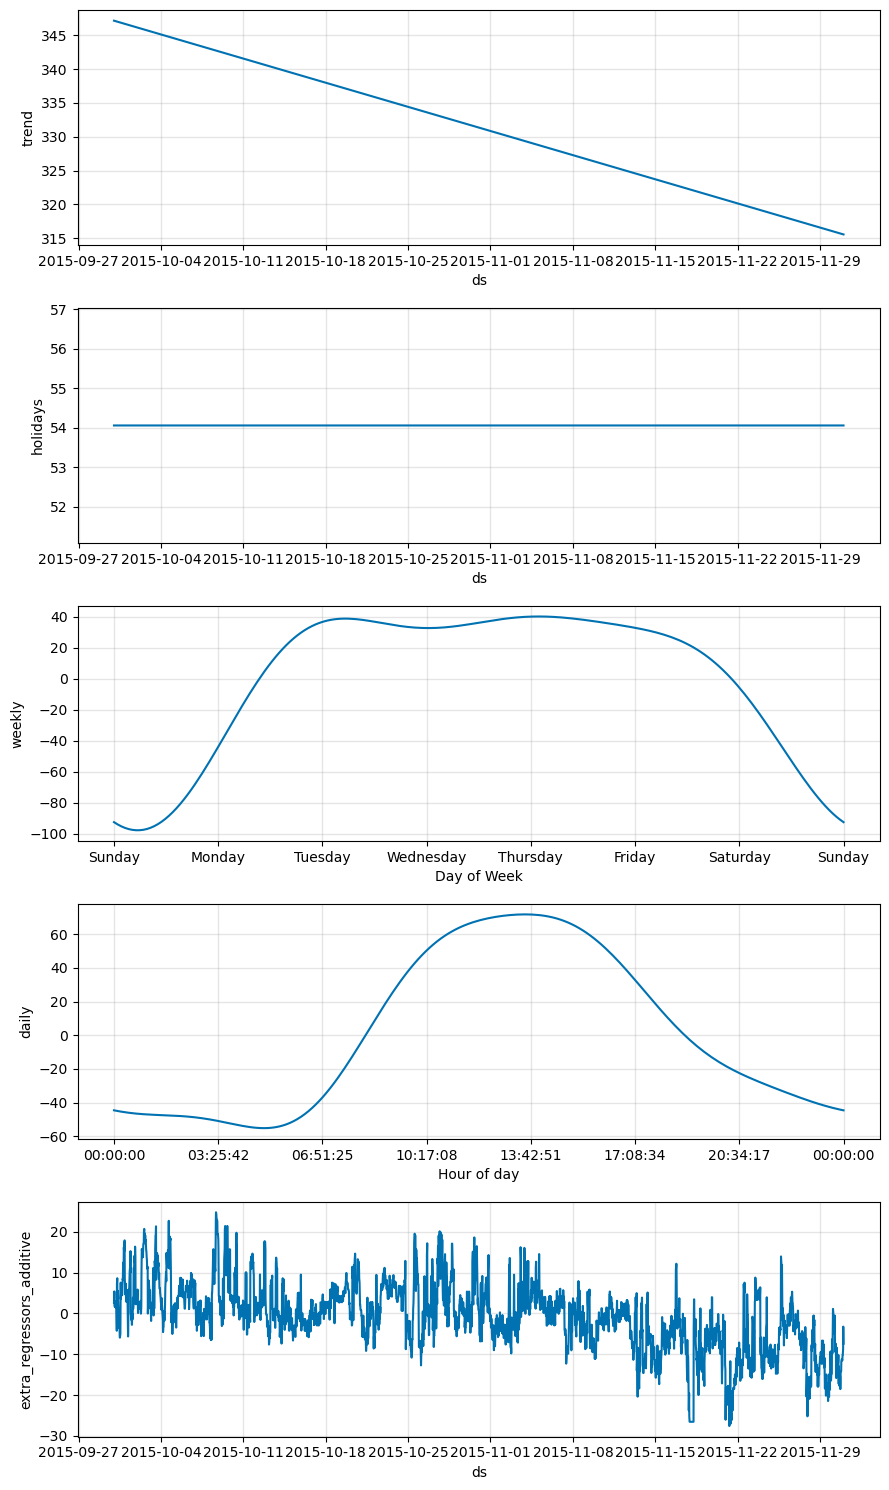

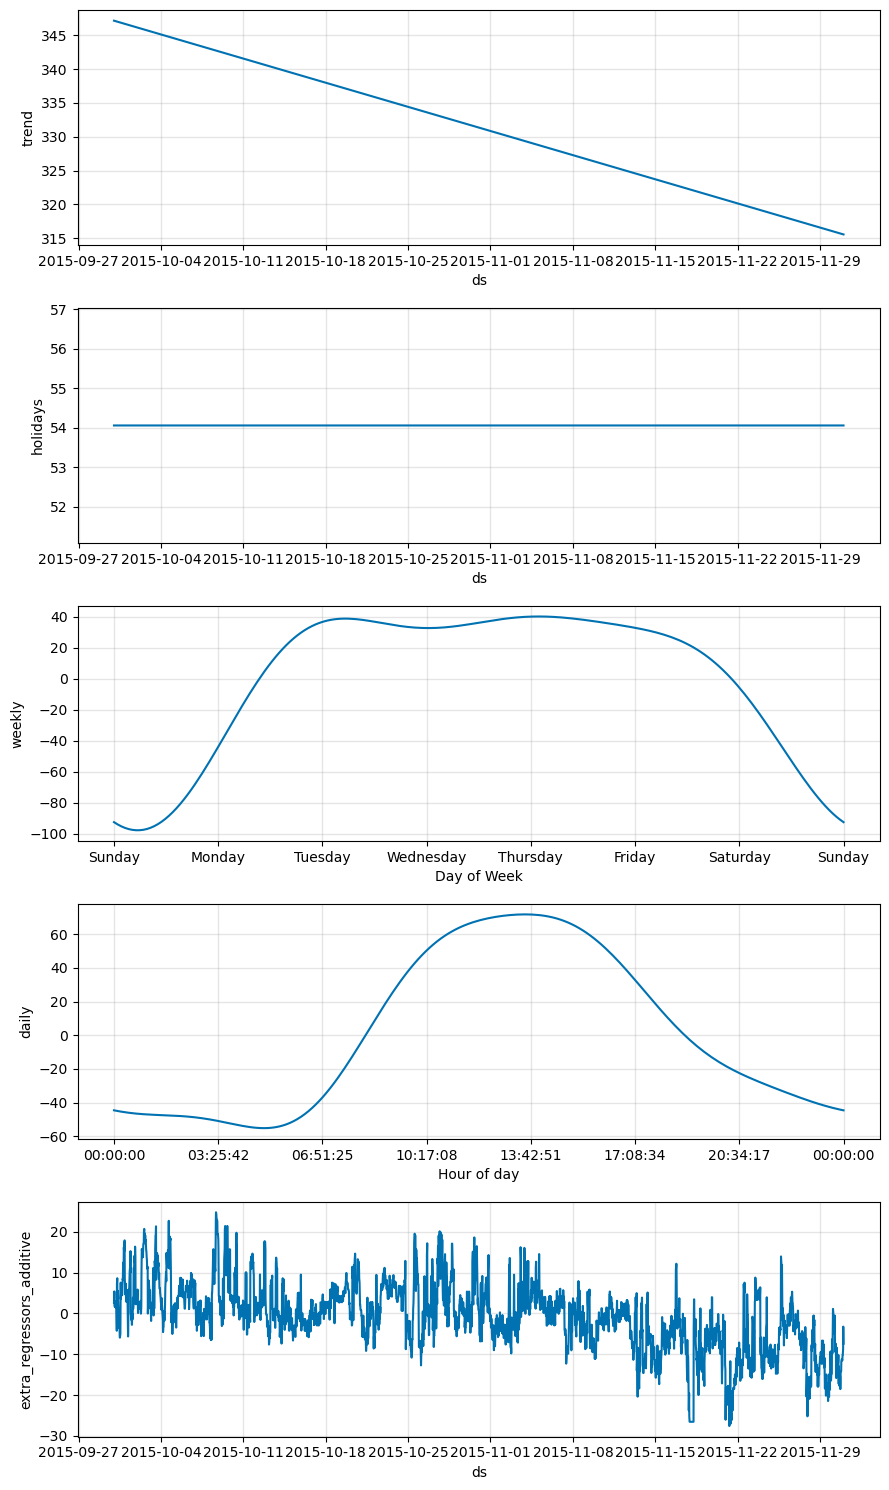

In [267]:
# Visualize the components' importance
model.plot_components(test_predictions, uncertainty=False)

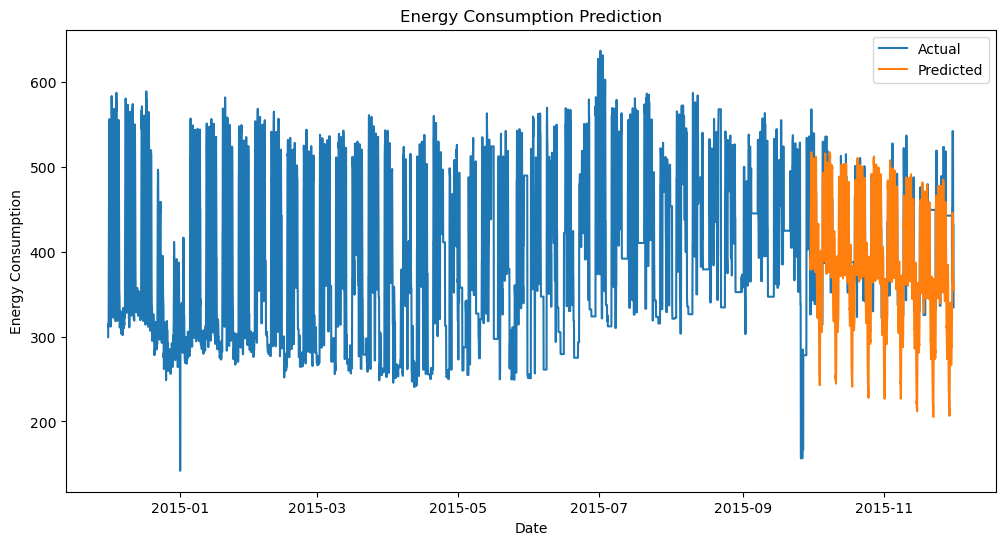

In [268]:
# Plot predictions on test data
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual test data
ax.plot(newData.index, newData['Office_Garman'], label='Actual')

# Plot predicted values
ax.plot(test.index, test_predictions['yhat'], label='Predicted')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption')
ax.set_title('Energy Consumption Prediction')

# Add a legend
ax.legend()

# Show the plot
plt.show()

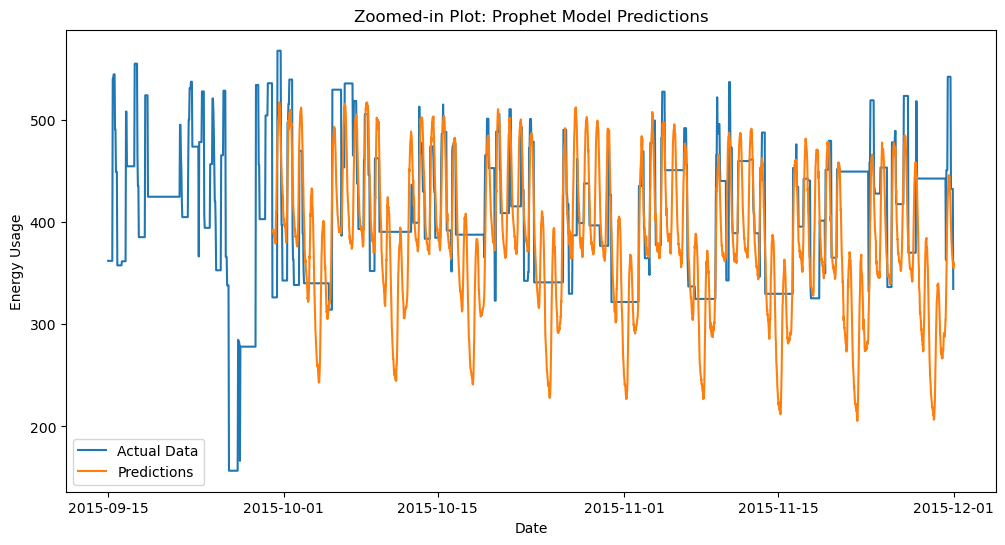

In [272]:
# Plot zoomed-in version
zoom_start_date = pd.to_datetime('2015-09-15')
zoom_end_date = pd.to_datetime('2015-12-10')
zoomed_data = newData[(newData.index >= zoom_start_date) & (newData.index <= zoom_end_date)]
zoomed_predictions = test_predictions[(test_predictions["ds"] >= zoom_start_date) & (test_predictions["ds"] <= zoom_end_date)]

plt.figure(figsize=(12, 6))
plt.plot(zoomed_data.index, zoomed_data["Office_Garman"], label='Actual Data')
plt.plot(zoomed_predictions["ds"], zoomed_predictions["yhat"], label='Predictions')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.title('Zoomed-in Plot: Prophet Model Predictions')
plt.legend()
plt.show()


In [270]:
# Remove rows with missing values
test_clean = test.dropna(subset=["Office_Garman"])
predicted_clean = predicted_values[:len(test_clean)]

# Calculate evaluation metrics
mae = mean_absolute_error(test_clean["Office_Garman"].values, predicted_clean)
mape = mean_absolute_percentage_error(test_clean["Office_Garman"].values, predicted_clean)
rmse = np.sqrt(mean_squared_error(test_clean["Office_Garman"].values, predicted_clean))

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)


MAE: 77.96369784709994
MAPE: 0.19489948275036734
RMSE: 94.7091792272785
